# Анализ бизнес-показателей

Маркетологи Яндекс.Афиши поставили задачу проанализировать логи посещений, выгрузку заказов и статистику рекламных расходов, чтобы найти способы оптимизации макретингового бюджета. 
<br>
Все данные за 01-06-2017 -- 31.05.2018
<details>
 Структуры таблиц.
    <dl>
  <dt><i>visits</i></dt>
   <dd> <i>Uid</i> — уникальный идентификатор пользователя </dd>
   <dd> <i>Device</i> — категория устройства пользователя </dd>
   <dd> <i>Start Ts</i> — дата и время начала сессии </dd>
   <dd> <i>End Ts</i> — дата и время окончания сессии </dd>
   <dd> <i>Source Id</i> — идентификатор источника перехода на сайт </dd>
  <dt><i>orders</i></dt>
   <dd> <i>Uid</i> — уникальный идентификатор пользователя,
   <dd> <i>Buy Ts</i> — дата и время заказа,
   <dd> <i>Revenue</i> — сумма заказа.
  <dt><i>costs</i></dt>
   <dd> <i>source_id</i> — идентификатор рекламного источника </dd>
   <dd> <i>dt</i> — дата проведения рекламной кампании </dd>
   <dd> <i>costs</i> — расходы на эту кампанию </dd>
 </dl>
</details>

## Структура проекта
1. [Начало работы](#start)
6. [Обработка данных](#processing)
6. [Анализ](#analisys)
6. [Выводы](#conclusions)

## Начало работы
<a id='start'></a>
<a name='start'></a>
Импортируем необходимые библиотеки, создадим необходимые переменные, познакомимся с данными, сделаем базовую предобработку.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
months = mdates.MonthLocator()

In [4]:
DATES = '06/2017-06/2018'

In [5]:
sns.set(
    rc = {
        'figure.figsize': (15, 7),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'both',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        'ytick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)

In [6]:
def read_csv(func: 'pd.read_csv'=pd.read_csv) ->pd.DataFrame:
    """Wrapper for pd.read_csv."""
    def wrapper(*args, **kwargs: 'pd.read_csv parameters') -> pd.DataFrame:
        """
        Return a DataFrame from csv with true and ordered columns and sort by
        datetime, and display 5 randow rows and df.info().
        """
        df = func(*args, **kwargs)
        
        columns_indeces = kwargs.get(
            'usecols', 
            np.arange(df.shape[1])
        )
        df = df.iloc[:, columns_indeces]

        df.columns = (df.columns
            .str.strip()
            .str.replace(' ', '_')
            .str.lower()
        )

        date_column = df.select_dtypes('datetime').columns[0]
        df = df.sort_values(date_column).reset_index(drop=True)

        display(
            df.sample(5, random_state=42).sort_index()
        )
        print('---------------------------------')
        df.info(memory_usage='deep')

        return df
    return wrapper

true_read_csv = read_csv()

In [7]:
visits = true_read_csv(
    filepath_or_buffer = '/datasets/visits_log.csv',
    dtype = {2: 'uint8'},
    parse_dates = [1, 3],
    usecols = [4, 3, 0, 2, 1],
)

,uid,start_ts,device,source_id,end_ts
37842,6319998500047660623,2017-08-10 02:53:00,touch,2,2017-08-10 02:58:00
247808,6575700767752425670,2018-02-11 14:58:00,desktop,10,2018-02-11 14:58:00
251085,5642353464768396578,2018-02-13 20:47:00,desktop,5,2018-02-13 20:50:00
321132,16633236947326926369,2018-04-18 14:05:00,desktop,1,2018-04-18 14:09:00
327288,2716826902763030318,2018-04-24 15:29:00,desktop,1,2018-04-24 15:44:00


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   uid        359400 non-null  uint64        
 1   start_ts   359400 non-null  datetime64[ns]
 2   device     359400 non-null  object        
 3   source_id  359400 non-null  uint8         
 4   end_ts     359400 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1), uint64(1), uint8(1)
memory usage: 30.3 MB


In [8]:
orders = true_read_csv(
    filepath_or_buffer = '/datasets/orders_log.csv',
    parse_dates = [0],
    usecols = [2, 0, 1],
)

,uid,buy_ts,revenue
1655,13203527169223228134,2017-06-19 18:39:00,19.86
9317,11785751562598603943,2017-09-27 14:32:00,0.98
24526,10376975812117698225,2017-12-17 01:14:00,1.34
42778,15888599410730719596,2018-03-29 23:51:00,1.17
43841,12161916031543310791,2018-04-12 09:23:00,7.33


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   uid      50415 non-null  uint64        
 1   buy_ts   50415 non-null  datetime64[ns]
 2   revenue  50415 non-null  float64       
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [9]:
costs = true_read_csv(
    filepath_or_buffer = '/datasets/costs.csv',
    dtype = {0: 'uint8'},
    parse_dates = [1],
)

,source_id,dt,costs
498,3,2017-08-11,165.68
564,1,2017-08-20,37.04
727,4,2017-09-12,181.70
1463,2,2017-12-27,144.42
1642,9,2018-01-21,13.24


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   uint8         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), uint8(1)
memory usage: 42.3 KB


Пропусков нет, типы данных теперь совпадают с ожидаемыми.
<br>
Посмотрим на дубликаты (за дубликат примем совпадающеи идентификаторы пользователя *uid* и время события *start_ts, buy_ts*), и сразу удалим их (оставив первое вхождение):

In [10]:
visits[visits[['uid', 'start_ts']].duplicated(keep=False)]

,uid,start_ts,device,source_id,end_ts
288384,1981020429381477763,2018-03-16 08:55:00,touch,1,2018-03-16 08:57:00
288386,1981020429381477763,2018-03-16 08:55:00,touch,1,2018-03-16 08:55:00


<font color='gray'>Видно, что совпадают также и поля *source_id* и *device*, что говорит в пользу какой-то технической ошибки.<font>

In [11]:
visits = visits.drop_duplicates(
    subset = ['uid', 'start_ts']
).reset_index(drop=True)

In [12]:
orders[orders[['uid', 'buy_ts']].duplicated()]

,uid,buy_ts,revenue


In [13]:
costs[costs.duplicated()]

,source_id,dt,costs


Поищем мусор:

In [14]:
visits['device'].value_counts()

desktop    262567
touch       96832
Name: device, dtype: int64

In [15]:
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34120
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

В *visits*, на первый взгляд, всё нормально. Если что-то всё-таки вылезет - разберёмся на месте.
<br>
Посмотрим на *revenue* в таблице *orders*:

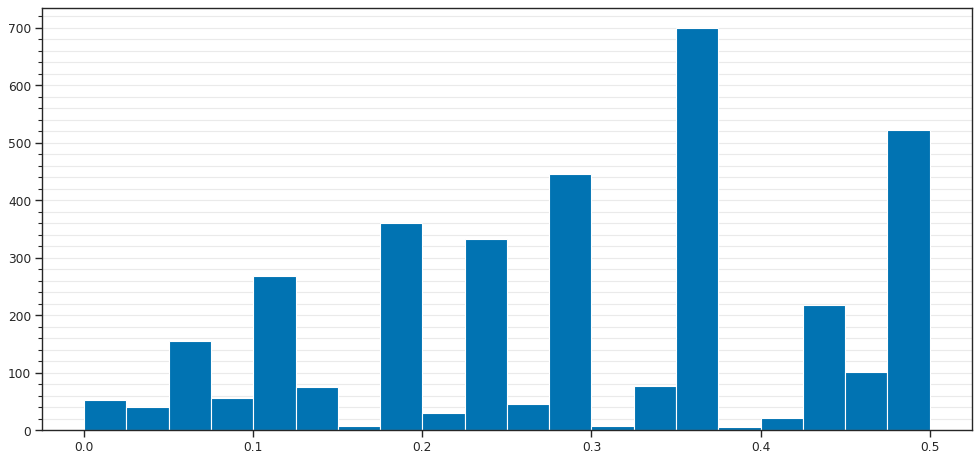

In [16]:
orders['revenue'].hist(bins=20, range=(0, 0.5))
plt.grid(None, axis='x')

Видно, что имеется порядка 50 нулевых значений. Посмотрим, есть ли какие-нибудь паттерны появления аномалии:

In [17]:
(orders[orders['revenue'] < 0.001] #0.001 из-за типа данных float
    .astype({'buy_ts': 'datetime64[M]'})
    .groupby('buy_ts')['revenue']
    .count()
) 

buy_ts
2017-06-01     1
2017-07-01     1
2017-08-01     4
2017-09-01     4
2017-10-01     2
2017-11-01    15
2017-12-01    12
2018-02-01     1
2018-03-01     1
2018-04-01     8
2018-05-01     2
Name: revenue, dtype: int64

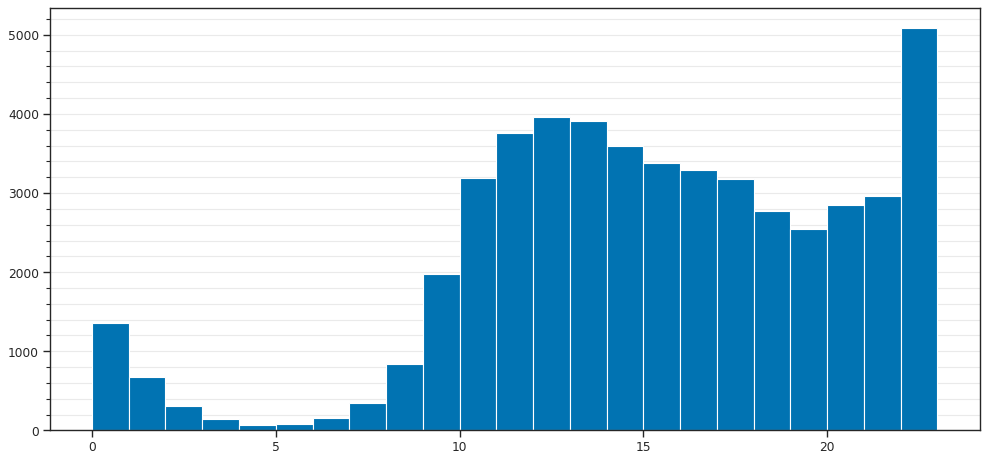

In [18]:
orders['buy_ts'].dt.hour.hist(bins=23)
plt.grid(None, axis='x')

In [19]:
(orders['revenue'] < 0.001).sum() / orders['revenue'].shape[0]

0.0010116036893781614

Видно, что нулевые значения сконцентрированы в 11 и 12 месяце и второй половине дня. Эту информацию стоит передать разработчикам, а мы пока смело дропнем эти строки, потому что их всего 0.1% от всего датасета:

In [20]:
orders = orders[orders['revenue'] > 0.001].reset_index(drop=True)

На всякий случай так же оставим только данные за нужный период:

In [21]:
for df in (visits, orders, costs):
    rows = df.shape[0]

    date_col = df.select_dtypes('datetime').columns[0]
    indices = df[
        (df[date_col] < '2017-06-01') |
        (df[date_col] >= '2018-06-01')
        ].index

    df.drop(indices, inplace=True)
    df.reset_index(drop=True, inplace=True)

    rows -= df.shape[0]
    print(f'Исключилось {rows} строк')

Исключилось 0 строк
Исключилось 1 строк
Исключилось 0 строк


___

## Обработка данных
<a id='processing' name='processing'></a>
Внимательнее посмотрим на дaнные, сгенерируем необходимую информацию.

Переименуем некоторые столбцы для удобства:

In [22]:
visits = visits.rename(columns={'start_ts': 'event_ts'})
orders = orders.rename(columns={'buy_ts': 'event_ts'})

Для дальнейшей работы нам нужны новые поля: месяц первого захода и первой покупки для каждого пользователя, lifetime когорт, месяц события, номер дня недели, недели, месяца:

In [23]:
for df in (visits, orders):
    df['event_day'] = df['event_ts'].astype('datetime64[D]')
    df['event_month'] = df['event_ts'].astype('datetime64[M]')
    df['first_month'] = df.groupby('uid')['event_month'].transform('min')
    df['lifetime'] = (
        (df['event_month'] - df['first_month']) / np.timedelta64(1, 'M')
        ).round().astype('uint8')

costs['month'] = costs['dt'].astype('datetime64[M]')
visits['event_week'] = (
    visits['event_day'] - pd.to_timedelta(visits['event_ts'].dt.dayofweek, unit='d')
    )

Так же нам пригодится поле с продолжительностью сессии:

In [24]:
visits['session_len_sec'] = (visits['end_ts'] - visits['event_ts']).dt.seconds

___

## Анализ данных
<a id='analisys'></a>
<a name='analisys'></a>
Непосредственно аналитика.
<br>
Посмотрим на разные метрики, построим разные графики, посмотрим на них тоже.

Начнём с продуктовой аналитики. 
<br>
Посмотрим на изменения 
<i style="font-style: normal; border-bottom: 1px dashed gray;" title="Daily Active Users">DAU</i>, 
<strike>ВАУ</strike>
<i style="font-style: normal; border-bottom: 1px dashed gray;" title="Weekly Active Users">WAU</i>, 
<i style="font-style: normal; border-bottom: 1px dashed gray;" title="Monthly Active Users">MAU</i>
во времени.
<br>
DAU:

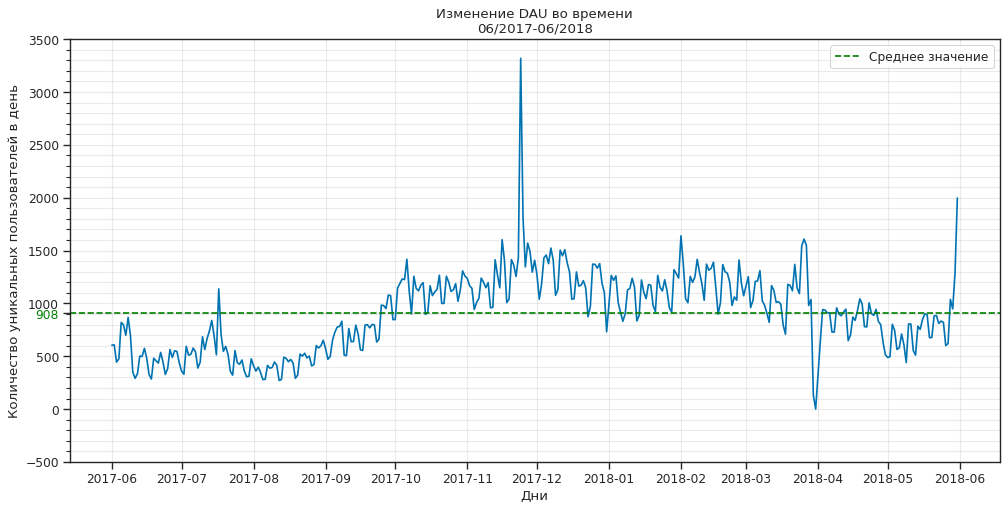

In [25]:
data = visits.groupby('event_day')['uid'].nunique()

ax = sns.lineplot(data=data)

ax.xaxis.set_major_locator(months)

plt.title(f'Изменение DAU во времени\n{DATES}')
plt.ylabel('Количество уникальных пользователей в день')
plt.xlabel('Дни')

plt.axhline(data.mean(), color='green', label='Среднее значение', ls='--')

plt.yticks(ticks=np.append(plt.yticks()[0], data.mean()))
plt.gca().get_yticklabels()[-1].set(color = 'green')
plt.legend()

plt.show()

Среднее значение DAU за весь период - **908**

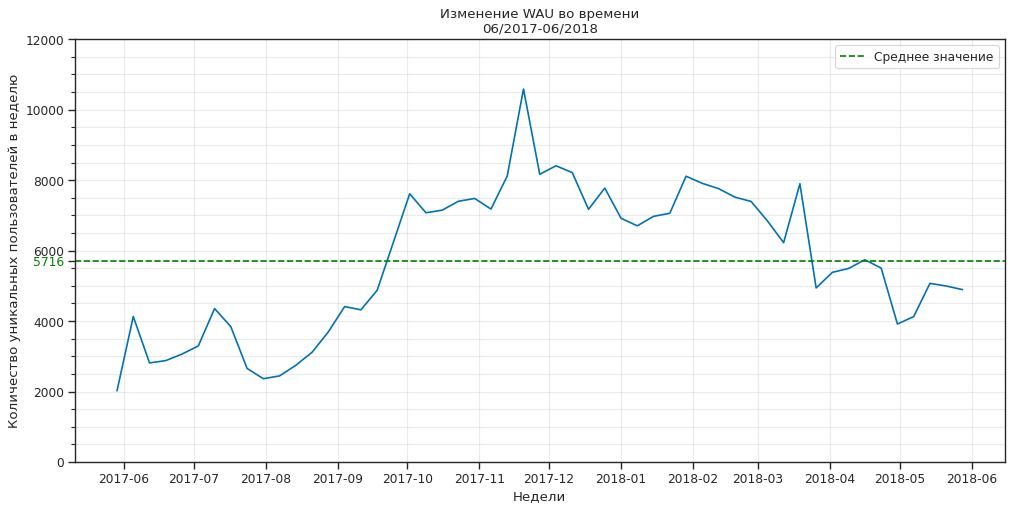

In [26]:
data = visits.groupby('event_week')['uid'].nunique()

ax = sns.lineplot(data=data)

ax.xaxis.set_major_locator(months)

plt.title(f'Изменение WAU во времени\n{DATES}')
plt.ylabel('Количество уникальных пользователей в неделю')
plt.xlabel('Недели')

plt.axhline(data.mean(), color='green', label='Среднее значение', ls='--')

plt.yticks(ticks=np.append(plt.yticks()[0], data.mean()))
plt.gca().get_yticklabels()[-1].set(color = 'green')
plt.legend()

plt.show()

Среднее значение WAU за весь период - **5716**

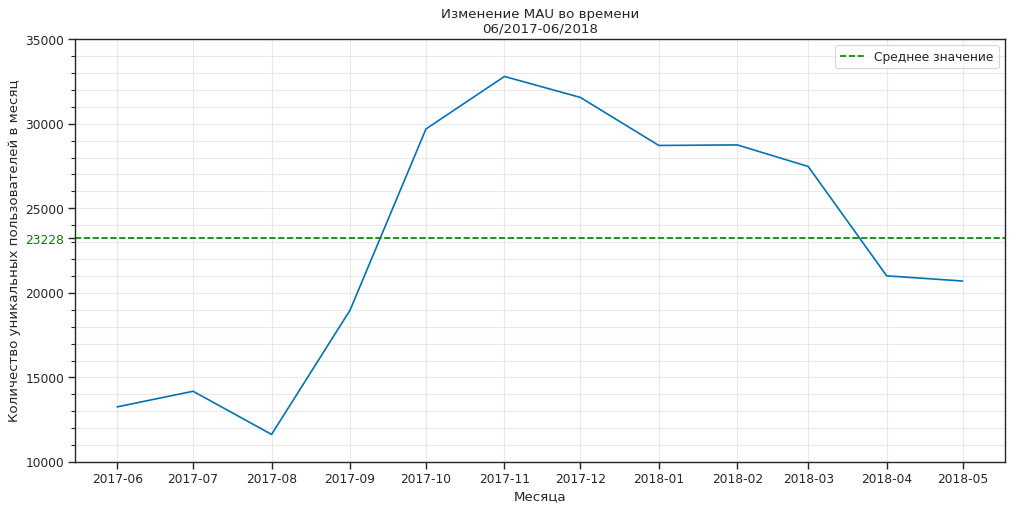

In [27]:
data = visits.groupby('event_month')['uid'].nunique()

ax = sns.lineplot(data=data)

ax.xaxis.set_major_locator(months)

plt.title(f'Изменение MAU во времени\n{DATES}')
plt.ylabel('Количество уникальных пользователей в месяц')
plt.xlabel('Месяца')

plt.axhline(data.mean(), color='green', label='Среднее значение', ls='--')

plt.yticks(ticks=np.append(plt.yticks()[0], data.mean()))
plt.gca().get_yticklabels()[-1].set(color = 'green')
plt.legend()

plt.show()

Среднее значение MAU за весь период - **23228**

Видно, что число уникальных пользователей на всех графиках растёт осенью с пиками зимой, а весной идёт на спад. 

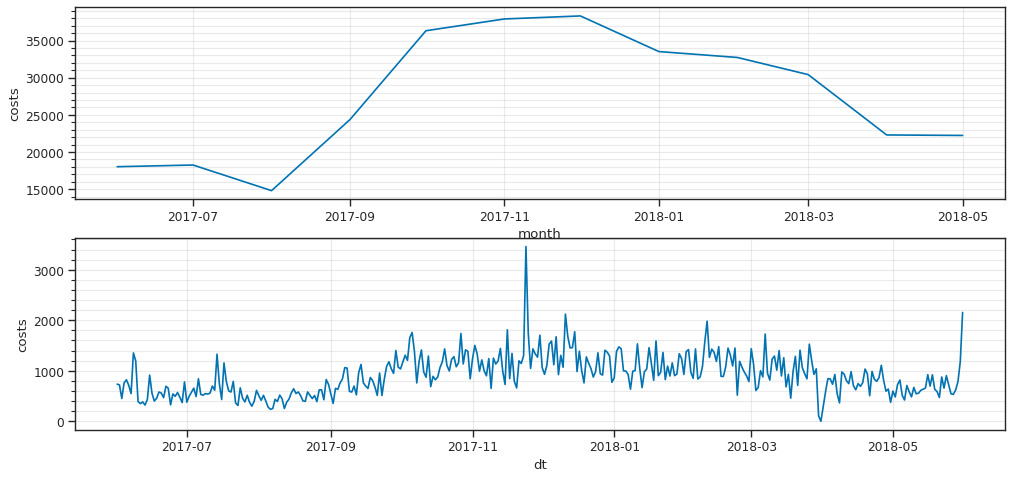

In [28]:
fig, axes = plt.subplots(2, 1)

for ax, col in zip(axes.flat, ('month', 'dt')):
    data = costs.groupby(col)['costs'].sum()
    sns.lineplot(
        data = data,
        ax = ax
    )

Получается, число уникальных пользователей напрямую зависит от размеров маркетинговых вливаний, что можно заметить из похожести графиков.

---

Но пойдём дальше. 
<br>
На очереди у нас среднее количество заходов в день на пользователя. 
<br>
Посмотрим на изменение его во времени:

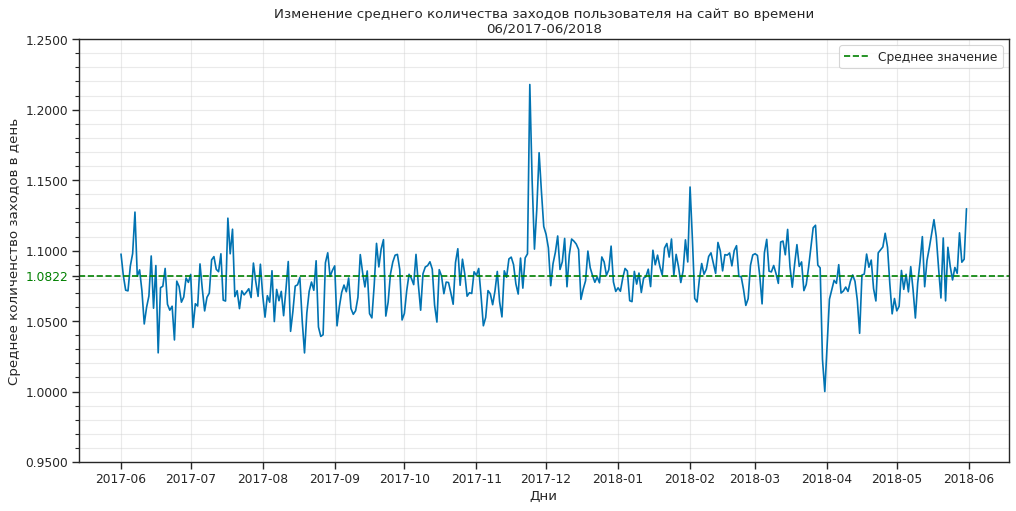

In [29]:
data = visits.groupby('event_day')['uid'].apply(lambda x: x.value_counts().mean())

ax = sns.lineplot(data=data)

ax.xaxis.set_major_locator(months)

plt.title(f'Изменение среднего количества заходов пользователя на сайт во времени\n{DATES}')
plt.ylabel('Среднее количенство заходов в день')
plt.xlabel('Дни')

plt.axhline(data.mean(), color='green', label='Среднее значение', ls='--')

plt.yticks(ticks=np.append(plt.yticks()[0], data.mean()))
plt.gca().get_yticklabels()[-1].set(color = 'green')
plt.legend()

plt.show()

Среднее количество заходов пользователя за весь период - **1.08*

Видим, что в среднем люди заходят примерно одинаковое количество раз, но пики этой метрики совпадают с пиками DAU

---

Теперь посмотрим сначала на распределение продолжительности сессий, а потом узнаем, какую сессию можно назвать средней:

<AxesSubplot:>

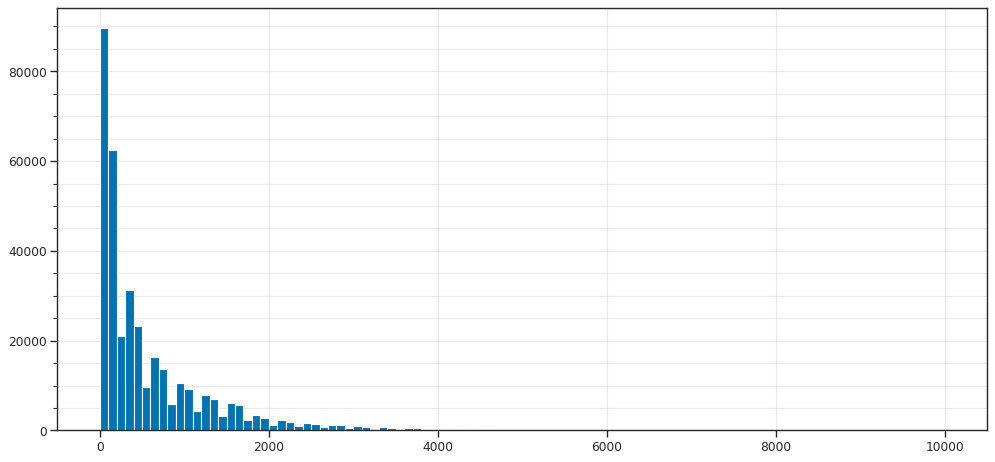

In [30]:
visits['session_len_sec'].hist(bins=100, range=(0, 10000))

Так как распределение далеко не нормальное, испльзуем для рассчёта средней сессии медиану:

In [31]:
print(f"Средняя пользовательская сессия за {DATES} равна {visits['session_len_sec'].median()} секунд")

Средняя пользовательская сессия за 06/2017-06/2018 равна 300.0 секунд


---

Настало время когортного анализа. 
<br>
Рассчитаем Retention Rate:

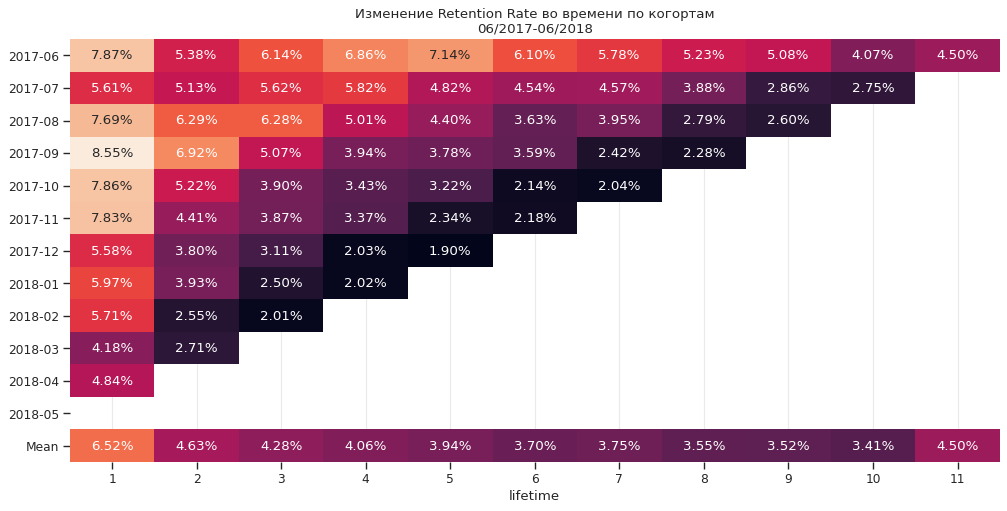

In [32]:
data = visits.groupby(['first_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()

data['starts'] = data.groupby('first_month')['uid'].transform('max')
data['retention'] = data['uid'] / data['starts']

ax = sns.heatmap(
    data = data.pivot_table(
        index='first_month', 
        columns='lifetime', 
        values='retention',
        margins = True,
        margins_name = 'Mean'
        ).drop(columns=[0, 'Mean']),
    annot = True,
    fmt='.2%',
    cbar = None
)

ax.set_yticklabels(item.get_text()[:7] for item in ax.get_yticklabels())

plt.minorticks_off()
plt.title(f'Изменение Retention Rate во времени по когортам\n{DATES}')
plt.ylabel('')
plt.grid(axis='x')
plt.show()

Средннее удержание на второй месяц жизни когорт составило **6.5%**.
<br>
Особенно выделяется первая когорта, которая показывает самое стабильное удержание на протяжении всей своей жизни.

---

Перейдём к коммерческим метрикам.
<br>
Рассчитаем, сколько времени проходит между первым визитом пользователя и его первой покупкой:

In [33]:
time_to_buy = (
    orders.groupby('uid')['event_ts'].min().to_frame()
    .rename(columns={'event_ts': 'first_buy'})
    .join(visits.groupby('uid')['event_ts'].min().rename('first_visit'))
    )

time_to_buy['ttb'] = (time_to_buy['first_buy'] - time_to_buy['first_visit']).dt.seconds

(time_to_buy['ttb'] / 60).describe()

count    36508.000000
mean       249.223266
std        429.774815
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: ttb, dtype: float64

Видно, что распределение опять не похоже на нормальное, и сильно перекошено влево. Поэтому опять используем для рассчёта среднего времени медиану.
<br>
В таком случае получается, что среднее время до покупки составляет **16 минут**, что говорит нам о том, что большинство пользователей совершают свою перую покупку во время первого захода на сайт.

---

Теперь посчитаем среднее количество покупок на одного покупателя за 6 месяцев:

In [34]:
orders.query("lifetime == 5").groupby('uid')['revenue'].count().mean()

1.921875

Получается, что средний пользователь за 6 месяцев совершает в районе двух покупок.

---

Взглянем на средний чек:

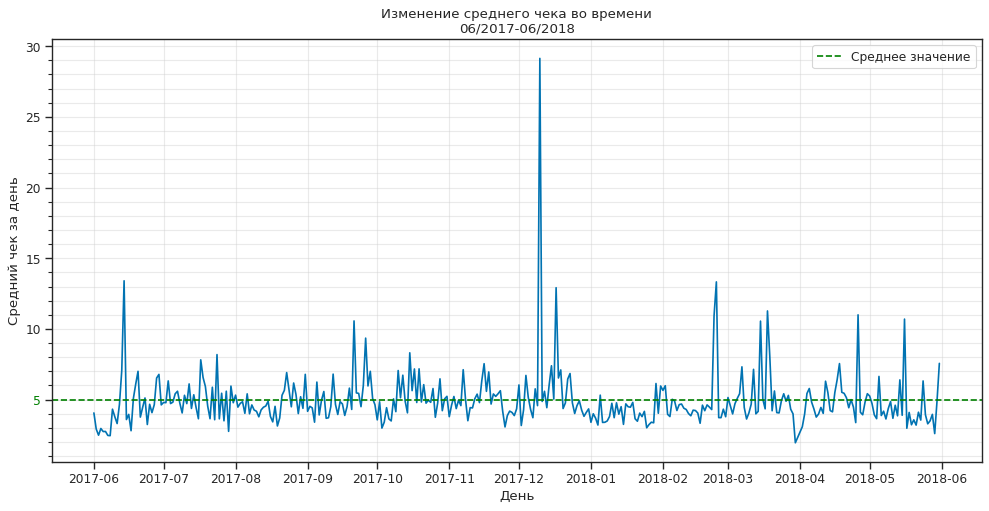

In [35]:
data = orders.groupby('event_day')['revenue'].mean()

ax = sns.lineplot(data=data)

ax.xaxis.set_major_locator(months)

plt.title(f'Изменение среднего чека во времени\n{DATES}')
plt.ylabel('Средний чек за день')
plt.xlabel('День')

plt.axhline(data.mean(), color='green', label='Среднее значение', ls='--')

plt.gca().get_yticklabels()[1].set(color = 'green')
plt.legend()

plt.show()

Средний чек за весь период - **5**

Как можно заметить, средний чек тоже держится примерно на одном уровне, с несколькими пиками. Возможно, пики совпадают с датами старта продаж билетов на какие-нибудь фестивали/концерты.

---

И, наконец, посмотрим на <i style="font-style: normal; border-bottom: 1px dashed gray;" title="LifeTime Value">LTV</i>.
<br>
Согласно имеющейся информации, маржинальность сервиса равна 100%, поэтому за прибыль просто возьмём поле *revenue*: 

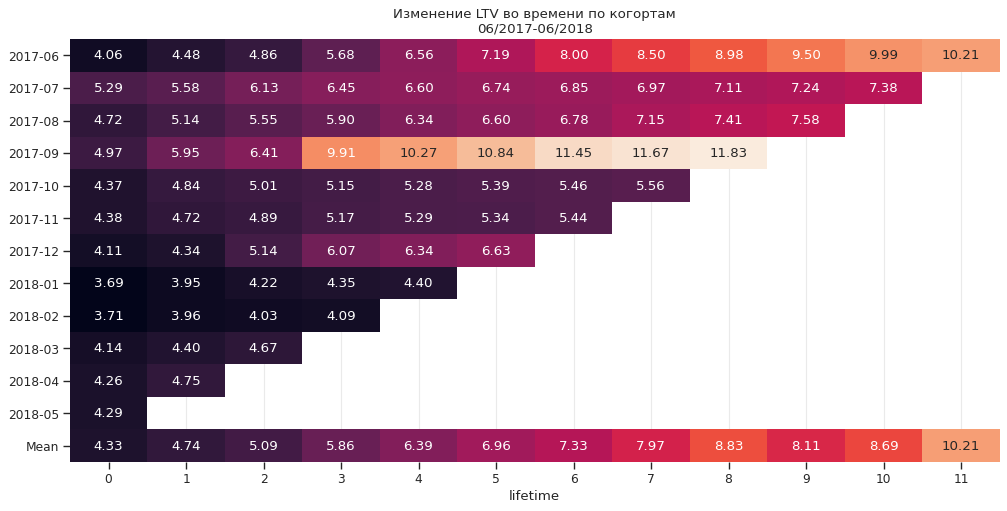

In [36]:
cohorts = (orders
            .groupby(['first_month', 'lifetime'])
            .agg({'revenue': 'sum', 'uid': 'count'})
            .rename(columns={'revenue': 'sum', 'uid': 'n_users'})
        ).reset_index()
cohorts['n_users'] = cohorts.groupby('first_month')['n_users'].transform('max')
cohorts['ltv'] = cohorts['sum'] / cohorts['n_users']

cohorts_pivot = cohorts.pivot_table(
                index = 'first_month',
                columns = 'lifetime',
                values = 'ltv',
            ).cumsum(axis=1)

ax = sns.heatmap(
    data = cohorts_pivot.append(
        cohorts_pivot.apply(lambda x: x.mean(), axis=0).rename('Mean')
    ),
    annot = True,
    fmt='.2f',
    cbar = None
)

plt.minorticks_off()
plt.grid(axis='x')
ax.set_yticklabels(item.get_text()[:7] for item in ax.get_yticklabels())
plt.title(f'Изменение LTV во времени по когортам\n{DATES}')
plt.ylabel('')
plt.show()

Видно, что на 6 месяц жизни когорты LTV в среднем равен **6.96**.
<br>
Первая когорта так же тут выделяется, но ещё больше выделяется сентябрьская.
<br>
Взглянем ещё на общий LTV:

In [37]:
orders['revenue'].sum() / orders['uid'].nunique()

6.904069792922099

---

Наконец, пройдёмся по маркетинговым метрикам.
<br>
Для начала, выделим для каждого пользователя его "главный" источник (тот, из которого он пришёл в первый раз):

In [38]:
sources = visits.groupby('uid')['source_id'].first()
visits = visits.join(sources.rename('first_source'), on='uid')
orders = orders.join(sources.rename('first_source'), on='uid')

In [39]:
sources.value_counts(normalize=True).to_frame().join(
    costs.groupby('source_id')['costs'].sum()
)

,source_id,costs
4,0.317072,61073.60
3,0.289768,141321.63
5,0.215792,51757.10
2,0.077206,42806.04
1,0.041500,20833.27
10,0.030254,5822.49
9,0.028260,5517.49
7,0.000140,NaN
6,0.000009,NaN


Большая часть пользователей пришла из источников **4, 3, 5.**
<br>
На эти же источники были потрачены самые большие суммы за год, но **3** источник стоил дороже, чем оставшиеся два вместе взятые.
<br>
Посмотрим на изменение трат во времени:

In [40]:
costs['cum_costs'] = costs.groupby('source_id')['costs'].transform(lambda x: x.cumsum())

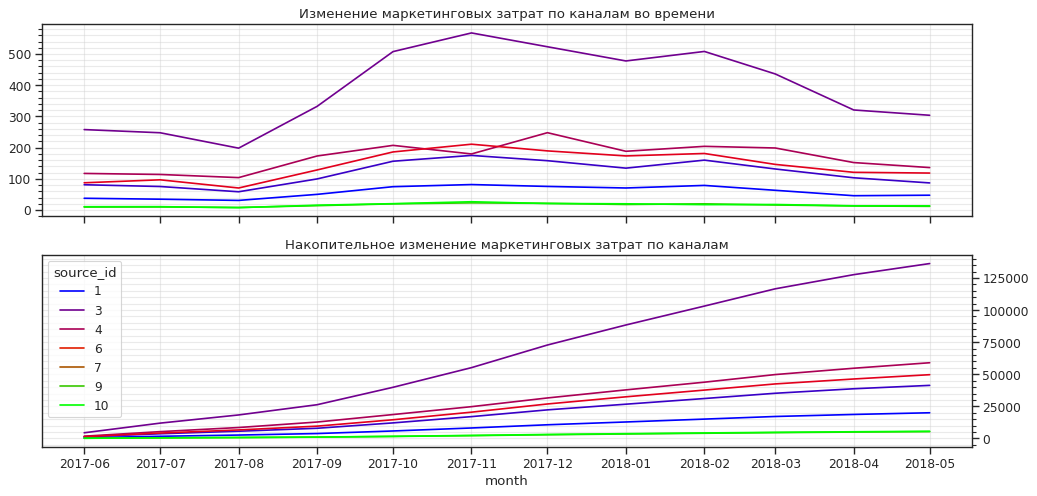

In [41]:
fig, axes = plt.subplots(2, 1)

for ax, col in zip(axes.flat, ('costs', 'cum_costs')):
    sns.lineplot(
        data = costs,
        x = 'month',
        y = col,
        hue = 'source_id',
        ci = None,
        palette = 'brg',
        ax = ax
    )
    if col == 'costs':
        ax.set(
            xticklabels = '',
            xlabel = '',
            ylabel = '',
            title = 'Изменение маркетинговых затрат по каналам во времени'
            )
        ax.legend().remove()
        ax.xaxis.set_major_locator(months)
        continue
    
    ax.xaxis.set_major_locator(months)
    ax.yaxis.tick_right()
    ax.set(
        title = 'Накопительное изменение маркетинговых затрат по каналам',
        ylabel = ''
        )

Посмотрим на <i style="font-style: normal; border-bottom: 1px dashed gray;" title="Customer Acqisition Cost">САС</i>.
<br>
Сначала общий:

In [42]:
costs['costs'].sum() / orders['uid'].nunique()

9.01532869508053

Теперь по источникам:

In [43]:
(
    costs.groupby('source_id')['costs'].sum().to_frame()
        .join(orders.groupby('first_source')['uid'].nunique())
        .apply(lambda x: x['costs'] / x['uid'], axis=1)
        .sort_values(ascending=False)
)

source_id
3     13.501637
2     12.219823
5      7.467479
1      7.193809
4      5.932356
9      5.071222
10     4.387709
dtype: float64

Видим, что дороже всех обходятся 3 и 2 каналы.

In [44]:
cohorts = cohorts.join(costs.groupby('month')['costs'].sum(), on='first_month')

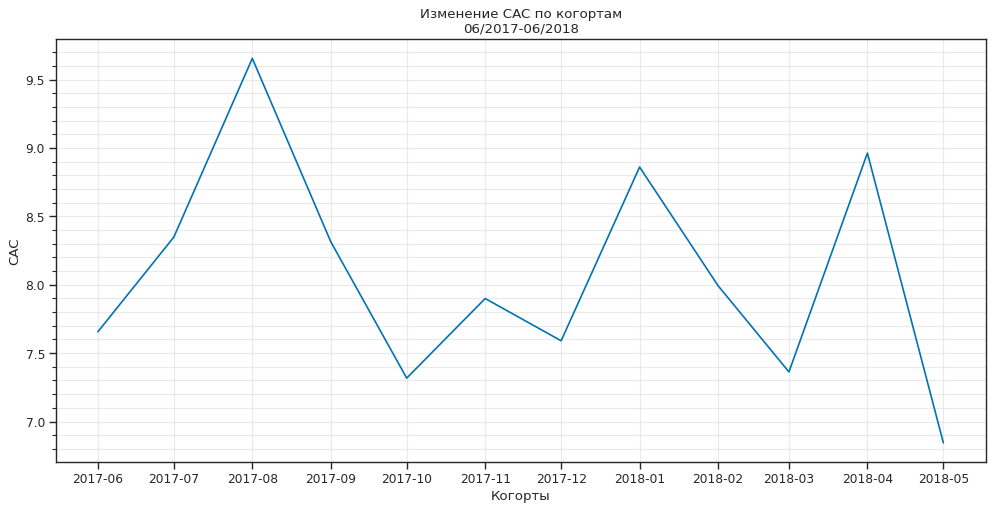

In [45]:
cohorts['cac'] = cohorts['costs'] / cohorts['n_users']

ax = sns.lineplot(
    data = cohorts.groupby('first_month')['cac'].first()
    )

ax.xaxis.set_major_locator(months)
plt.title(f'Изменение CAC по когортам\n{DATES}')
plt.xlabel('Когорты')
plt.ylabel('CAC')
plt.show()

Взглянем сразу на <i style="font-style: normal; border-bottom: 1px dashed gray;" title="Return on Marketing Investment">ROMI</i> по когортам:

In [46]:
cohorts['romi'] = cohorts['ltv'] / cohorts['cac']

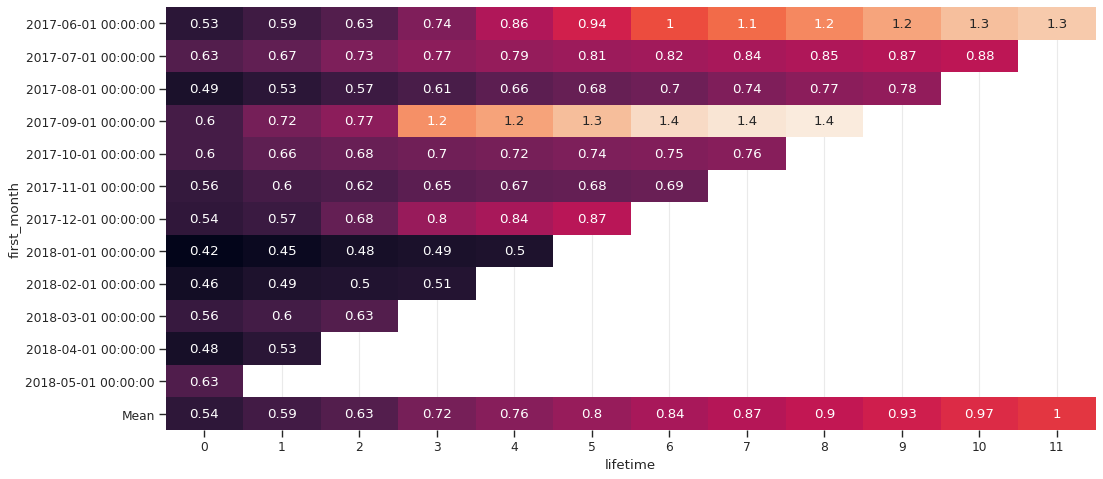

In [47]:
data = cohorts.pivot_table(
        index = 'first_month',
        columns = 'lifetime',
        values = 'romi',
        margins = True,
        margins_name = 'Mean'
    )
sns.heatmap(
    data = data.drop(columns='Mean').cumsum(axis=1),
    annot = True,
    cbar = None
)
ax.set_yticklabels(item.get_text()[:7] for item in ax.get_yticklabels())
plt.grid(axis='x')
plt.minorticks_off()

Интересно, что на данный момент все затраты окупаются в среднем к концу года.
<br>
Посмотрим, можно ли как-то оптимизировать каналы. 
<br>
Для этого построим тепловую карту среднего ROMI для каждого источника по его времени жизни:

In [48]:
source_cohorts = (
    orders
    .groupby(['first_source', 'first_month', 'lifetime'])
    .agg({'revenue': 'sum', 'uid': 'count'})
    .rename(columns={'revenue': 'sum', 'uid': 'n_users'})
    ).reset_index()

source_cohorts['n_users'] = (
    source_cohorts
    .groupby(['first_source', 'first_month'])['n_users']
    .transform('max')
    )

source_cohorts = (
    source_cohorts
    .join(
        costs.groupby(['source_id', 'month'])['costs'].sum(), 
        on=['first_source', 'first_month']
        )
    )
source_cohorts = source_cohorts.dropna(subset=['costs']).reset_index(drop=True)

source_cohorts['ltv'] = source_cohorts['sum'] / source_cohorts['n_users']
source_cohorts['cac'] = source_cohorts['costs'] / source_cohorts['n_users']
source_cohorts['romi'] = source_cohorts['ltv'] / source_cohorts['cac']
source_cohorts['mean_romi'] = (
    source_cohorts
    .groupby(['first_source', 'lifetime'])['romi']
    .transform(lambda x: x.mean())
    )

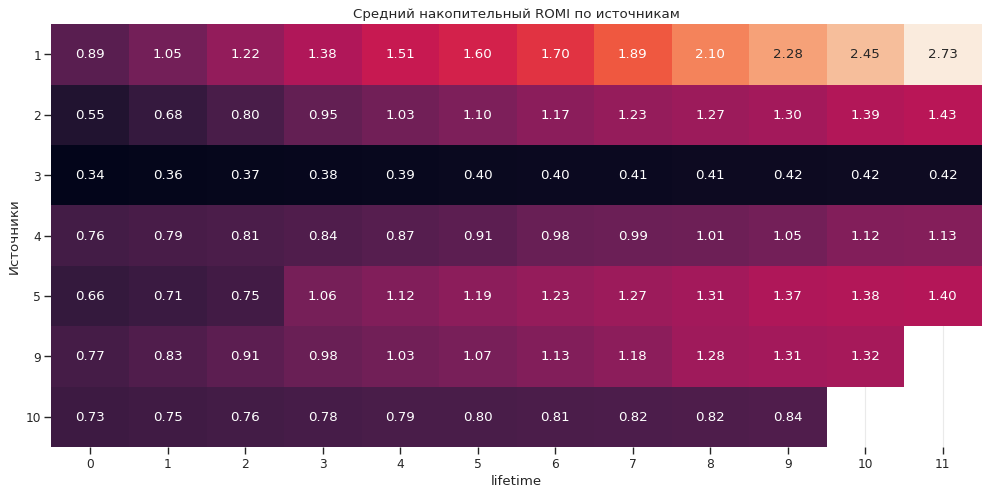

In [49]:
sns.heatmap(
    data = source_cohorts.pivot_table(
                index = 'first_source',
                columns = 'lifetime',
                values = 'mean_romi'
    ).cumsum(axis=1), 
    annot = True, 
    fmt = '.2f', 
    cbar = None, 
)

plt.minorticks_off()
plt.grid(axis='x')

plt.title('Средний накопительный ROMI по источникам')
plt.yticks(rotation=0)
plt.ylabel('Источники')

plt.show()

## Выводы
<a name='conclusions' id='conclusions'></a>
Сформулируем то, что хочет знать маркетинговый отдел.

Проанализировав данные, мы узнали, что самые активные каналы - **4, 3, 5**, причём лидером по затратам с огромным отрывом является канал номер 3 с бюджетом в 141к.
<br>
Однако, несмотря на максимальный бюджет и высокую активность, этот канал имеет самый низкий показатель ROMI, что значит что он не окупается от слова совсем. **Четвёртый** канал начинает окупаться в среднем на **9** месяц, а **пятый** — на **четвёртый**. Причём все три канала по выручке примерно на одном уровне, что позволяет сделать вывод о необходимости срочно обрубать канал номер **три** и обратить внимание на развитие канала с номером **пять**.
<br>
Что касается других каналов — по **седьмому** у нас нет никакой информации о тратах, и из этого канала пришёл всего один покупатель. Если есть какие-то расходы — о них тоже следует подумать. **Первый канал** может быть перспективным, так как он окупается в среднем уже на второй месяц. **Второй** канал окупается на пятый месяц, так же как и **девятый**. **Десятый** канал не окупается совсем.
<br>
Резюмируем: 
- **1 канал** - окупается на второй месяц
- **2 канал** - окупается на пятый месяц
- **3 канал** - самый бесперспективный - много людей, не окуппается, дороже всех
- **4 канал** - окупается на девятый месяц
- **5 канал** - самый перспективный - много людей, средние затраты, хорошая окупаемость
- **6 канал** - нет никакой информации
- **7 канал** - нет никакой информации
- **9 канал** - окупается на пятый месяц
- **10 канал** - не окупается вообще
<br>

Я бы расставил каналы по приоритету в таком порядке - **5, 1, 2, 9, 4**. По остальным каналам нужно или что-то менять, или отказываться от них совсем.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>